# Convolutional Neural Networks

## Theory

Neuron in the row $i$ and the column $j$ connects to the neurons outputs of the previous layer - these neurons are placed in the rows between $i$ to $i + f_h =1$ and columns from $j$ to $j+f_w-1$

- $f_h$ - receptive field's height
- $f_w$ - receptive field's width

It's possible to use **strides**

**stride** - distance between two successive receptive fields

Neuron in the row $i$ and the column $j$ connects to the neuron outputs of the previous layer - these neurons are placed in the rows between $i\times s_h$ to $i\times s_h + f_h =1$ and columns from $j\times s_w$ to $j\times s_w+f_w-1$

- $f_h$ - receptive field's height;
- $f_w$ - receptive field's width;
- $s_h$ - vertical stride;
- $s_w$ - horizontal stride

### Neuron output in the convolutional layer:

$z_{i,\:j,\:k}=b_k + \sum\limits_{u=0}^{f_h-1}\sum\limits_{\nu=0}^{f_w-1}
\sum\limits_{k'=0}^{f_{n'}-1}x_{i',\:j',\:k'}\cdot w_{u,\:\nu,\:k',\:k}$ with 
$\left\{\begin{array}{l}
i'=i\times s_h + u\\
j'=j\times s_w + \nu
\end{array}\right.
$

- $z_{i,\:j,\:k}$ - output of a neuron in the row $i$, column $j$, feature map $k$
- $f_h$ - receptive field's height; $f_w$ - receptive field's width; $s_h$ - vertical stride; $s_w$ - horizontal stride;
- $f_{n'}$ - number of feature maps in the previous layer (layer $l-1$);
- $x_{i',\:j',\:k'}$ - neuron output in layer $l-1$, row $i'$, column $j'$, feature map $k'$;
- $b_k$ - bias (brightness of feature map $k$);
- $w_{u,\:\nu,\:k',\:k}$ - weight between any neuron in the feature map $k$ of layer $l$ and its input in row $u$, column $\nu$ (regarding neuron receptive field) and feature map $k'$

Let's do some convolutional operations:

Input shape:

**[height, width, channels]** or **[mini-batch size, height, width, channels]** for mini-batch realization

Convolutional layer weights shape:

**[$f_h, f_w, f_{n'}, f_n$]**, where $f_n$ - number of feature maps on this layer

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_sample_image

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [19]:
def reset_graph():
    tf.reset_default_graph()

In [6]:
# load images
china = load_sample_image("china.jpg")
flower = load_sample_image("flower.jpg")
dataset = np.array([china, flower], dtype=np.float32)
batch_size, height, width, channels = dataset.shape

In [11]:
china[:3, 0, :]

array([[174, 201, 231],
       [172, 199, 229],
       [174, 201, 231]], dtype=uint8)

In [12]:
# filters creation
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

In [52]:
reset_graph()

In [53]:
# graph creation
X = tf.placeholder(dtype=tf.float32, shape=(None, height, width, channels))
convolution = tf.nn.conv2d(X, filters, strides=[1, 2, 2, 1], padding="SAME")

In [54]:
with tf.Session() as sess:
    output = sess.run(convolution, feed_dict={X: dataset})

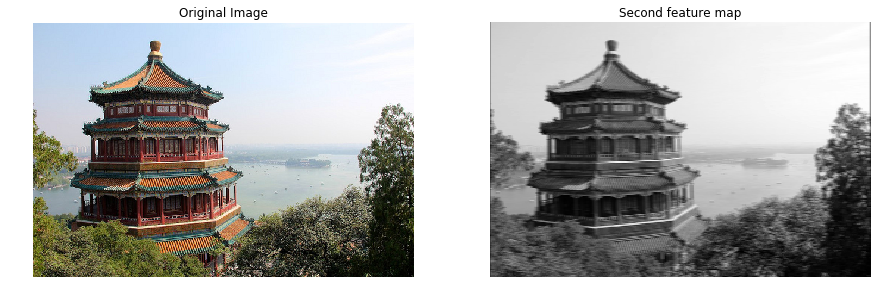

In [55]:
plt.figure(figsize=(15, 10))
plt.subplot(121)
plt.imshow(china)
plt.axis("off")
plt.title("Original Image")

# second feature map for the first image
plt.subplot(122)
plt.imshow(output[0, :, :, 1], cmap="gray")
plt.axis("off")
plt.title("Second feature map");

Creating convolutional layer automatically:

In [58]:
reset_graph()

In [59]:
X = tf.placeholder(shape=(None, height, width, channels), dtype=tf.float32)
conv = tf.layers.conv2d(X, filters=2, kernel_size=7, strides=[2, 2], padding="SAME")
init = tf.global_variables_initializer()

In [60]:
with tf.Session() as sess:
    init.run()
    output = sess.run(conv, feed_dict={X: dataset})

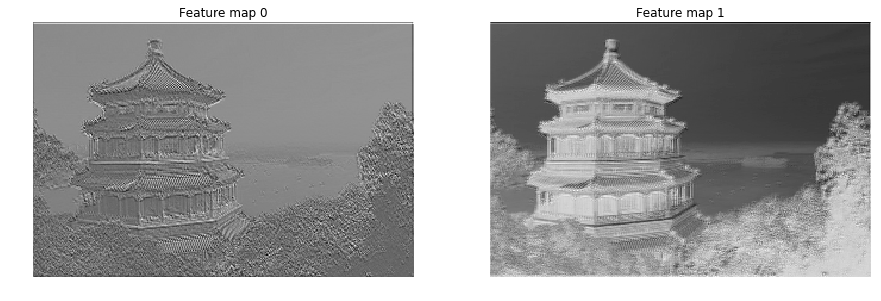

In [74]:
fig, axes = plt.subplots(1, 2)
fig.set_figheight(10)
fig.set_figwidth(15)
for fm_idx, ax in enumerate(axes):
    ax.imshow(output[0, :, :, fm_idx], cmap="gray")
    ax.axis("off")
    ax.set_title("Feature map {}".format(fm_idx));

## Pooling layer

In [106]:
reset_graph()

In [107]:
X = tf.placeholder(dtype=tf.float32, shape=(None, height, width, channels))
max_pool = tf.nn.max_pool(X, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")  # pooling by height and width
max_pool_d = tf.nn.max_pool(X, ksize=[1, 1, 1, 3], strides=[1, 1, 1, 3], padding="VALID")  # pooling by depth

In [108]:
with tf.Session() as sess:
    output, output_d = sess.run([max_pool, max_pool_d], feed_dict={X: dataset})

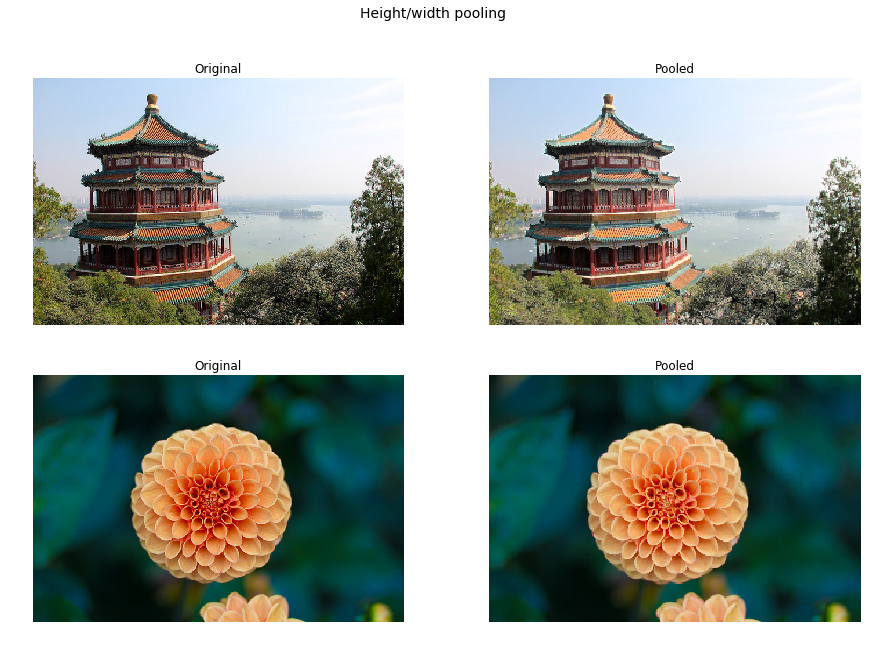

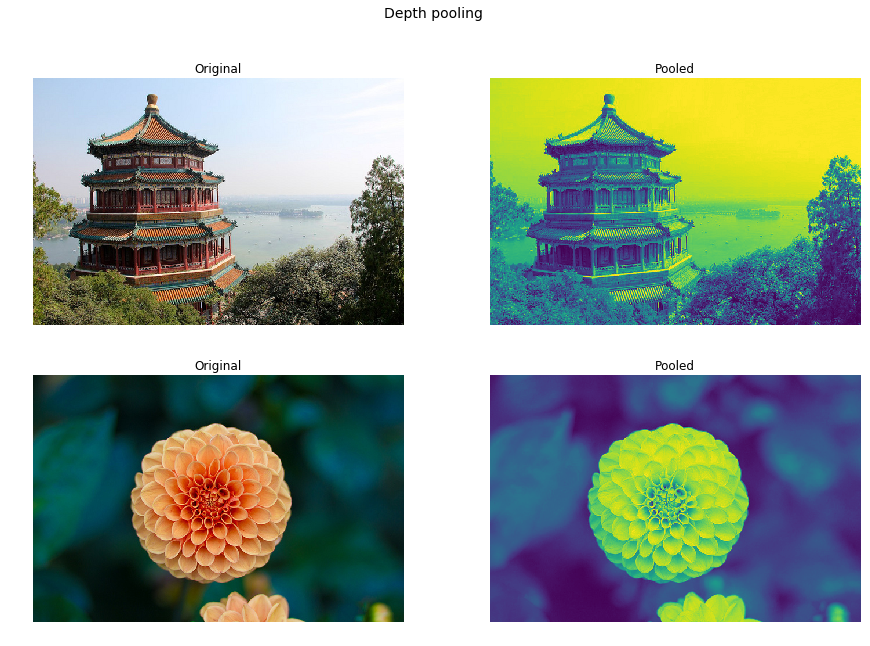

In [112]:
for number, outputs in enumerate([output, output_d]):
    fig, axes = plt.subplots(2, 2)
    fig.set_figheight(10)
    fig.set_figwidth(15)
    fig.suptitle("Height/width pooling", fontsize=14) if number == 0 else fig.suptitle("Depth pooling", fontsize=14)
    images = [china, outputs[0], flower, outputs[1]]
    for i, (img, ax) in enumerate(zip(images, axes.ravel())):
        ax.axis("off")
        if i % 2 == 0:
            ax.imshow(img)
            ax.set_title("Original")
        else:
            if number == 0:
                ax.imshow(img.astype(np.uint8))
            else:
                ax.imshow(img.reshape(img.shape[0], img.shape[1]))
            ax.set_title("Pooled");

## CNN - MNIST Dataset

In [15]:
np.random.seed(42)

In [3]:
def shuffle_batch(X, y, batchsize):
    indices = len(X)
    shuffle_indices = np.random.permutation(indices)
    n_batches = len(X) // batchsize
    for batch_idx in np.array_split(shuffle_indices, n_batches):
        X_batch = X[batch_idx]
        y_batch = y[batch_idx]
        yield X_batch, y_batch

In [4]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata("MNIST original")

In [10]:
X = mnist['data']
y = mnist['target']

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20)

In [17]:
X_test.shape

(14000, 784)

In [21]:
height = 28
width = 28
channels = 1
n_inputs = height * width

conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 2
conv2_pad = "SAME"

pool3_fmaps = conv2_fmaps

n_fc1 = 64
n_outputs = 10

reset_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(dtype=tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(dtype=tf.int32, shape=[None], name="y")

conv1 = tf.layers.conv2d(inputs=X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize, 
                         strides=conv1_stride, padding=conv1_pad, activation=tf.nn.relu, name="conv1")
conv2 = tf.layers.conv2d(inputs=conv1, filters=conv2_fmaps, kernel_size=conv2_ksize, 
                         strides=conv2_stride, padding=conv2_pad, activation=tf.nn.relu, name="conv2")

with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 7 * 7])

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat, n_fc1, activation=tf.nn.relu, name="fc1")

with tf.name_scope("outputs"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy, name="loss")
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

filewriter = tf.summary.FileWriter("../tf_logs/CNN_MNIST", tf.get_default_graph())

In [23]:
n_epochs = 10
batch_size = 100

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        accuracy_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print("Train accuracy: {:.3f}\tTest accuracy: {:.3f}".format(accuracy_train, accuracy_test))
    save_path = saver.save(sess, "../models/CNN_MNIST")

Train accuracy: 1.000	Test accuracy: 0.974
Train accuracy: 0.970	Test accuracy: 0.976
Train accuracy: 1.000	Test accuracy: 0.981
Train accuracy: 1.000	Test accuracy: 0.981
Train accuracy: 0.990	Test accuracy: 0.979
Train accuracy: 1.000	Test accuracy: 0.982
Train accuracy: 1.000	Test accuracy: 0.982
Train accuracy: 1.000	Test accuracy: 0.984
Train accuracy: 1.000	Test accuracy: 0.985
Train accuracy: 1.000	Test accuracy: 0.983


In [25]:
test_X, test_y = X_test[5], y_test[5]
test_y

7.0

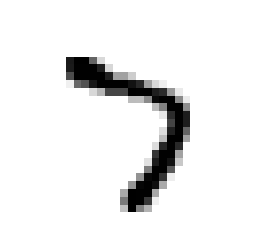

In [27]:
plt.imshow(test_X.reshape(28, 28), cmap="binary")
plt.axis("off");

In [30]:
with tf.Session() as sess:
    saver.restore(sess, save_path)
    print("Predicted value: ", np.argmax(Y_proba.eval(feed_dict={X: [test_X]})))

INFO:tensorflow:Restoring parameters from ../models/CNN_MNIST
Predicted value:  7
